# VQE example on a kagome lattice

## 1- Preparing the model

### Importing libraries and creating the lattice model

In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

TOKEN = "MY_TOKEN"

In [107]:
import os
from dotenv import load_dotenv

load_dotenv()

TOKEN = os.getenv('TOKEN')
print(TOKEN)

1922e96b1d747709e0c776db6e41619a4239c5f854c2052ded92599219fe9683cef168d0c8a4898b0d38223e8bc8de8c679b6a7f72db97db239c63cf436d8bfa


In [4]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

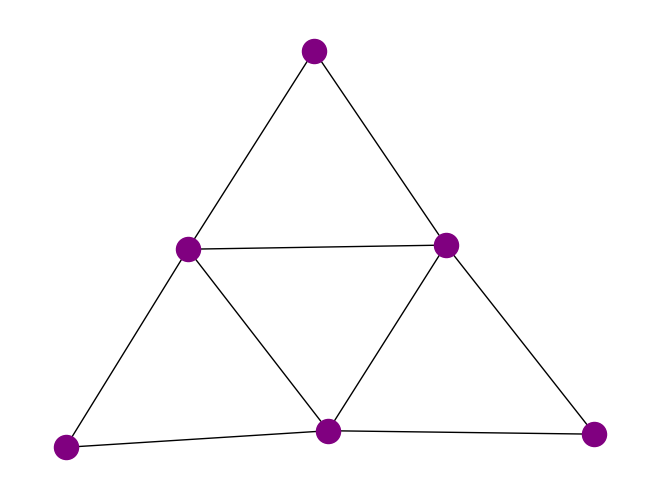

In [5]:
# Tri_star unit cell
num_sites = 6
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (0, 2, t),
    (0, 3, t),
    (3, 1, t),
    (1, 4, t),
    (4, 2, t),
    (2, 5, t),
    (5, 0, t)
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
tri_star_unit_cell = Lattice(graph)

# Draw Lattice
tri_star_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('tri_star_unit_cell.png')
plt.show()


### Converting the lattice model into a Hamiltonian

We use the structure of the lattice with a Heisenberg XXX model. For each edge we add a $XX + YY + ZZ$ term.

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [7]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=tri_star_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIZII', 'IZIZII', 'IZIIZI', 'IIZIZI', 'IIIZZI', 'ZIIIIZ', 'IIZIIZ', 'IIIZIZ', 'IIIIZZ', 'YIIYII', 'IYIYII', 'IYIIYI', 'IIYIYI', 'IIIYYI', 'YIIIIY', 'IIYIIY', 'IIIYIY', 'IIIIYY', 'XIIXII', 'IXIXII', 'IXIIXI', 'IIXIXI', 'IIIXXI', 'XIIIIX', 'IIXIIX', 'IIIXIX', 'IIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

### Compute ground state energy

In [11]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-9.         -9.         -7.72293753]


## 2- Running on a simulator

### Loading the IBM account

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN,
                                  overwrite = True)
service = QiskitRuntimeService(channel='ibm_quantum')
simulator = service.backend("simulator_statevector")



### Creating an ansatz

In [20]:
from qiskit.circuit.library import EfficientSU2
from ansatz import *

In [35]:
num_qub=6
qc = QuantumCircuit(num_qub)
 

j=0
for i in np.arange(0,num_qub-1):
    qc.cry(Parameter('θ_' + str(j)),i,i+1) 
    j +=1
    qc.cnot(i+1, i)
for i in np.arange(0,num_qub-1):
    qc.ry(Parameter('θ_' + str(j)),i) 
    j +=1
    qc.cnot(i, i+1)    
    
ansatz = qc
ansatz.draw(fold = 300)



┌───┐┌─────────┐                                                                                            
q_0: ─────■─────┤ X ├┤ Ry(θ_5) ├──────────■─────────────────────────────────────────────────────────────────────────────────
     ┌────┴────┐└─┬─┘└─────────┘┌───┐   ┌─┴─┐   ┌─────────┐                                                                 
q_1: ┤ Ry(θ_0) ├──■───────■─────┤ X ├───┤ X ├───┤ Ry(θ_6) ├─────■───────────────────────────────────────────────────────────
     └─────────┘     ┌────┴────┐└─┬─┘   └───┘   └──┬───┬──┘   ┌─┴─┐   ┌─────────┐                                           
q_2: ────────────────┤ Ry(θ_1) ├──■───────■────────┤ X ├──────┤ X ├───┤ Ry(θ_7) ├─────■─────────────────────────────────────
                     └─────────┘     ┌────┴────┐   └─┬─┘      └───┘   └──┬───┬──┘   ┌─┴─┐   ┌─────────┐                     
q_3: ────────────────────────────────┤ Ry(θ_2) ├─────■──────────■────────┤ X ├──────┤ X ├───┤ Ry(θ_8) ├──■──────────────────
                                     └─────────┘           ┌────┴────┐   └─┬─┘      └───┘   └──┬───┬──┘┌─┴─┐┌─────────┐     
q_4: ──────────────────────────────────────────────────────┤ Ry(θ_3) ├─────■──────────■────────┤ X ├───┤ X ├┤ Ry(θ_9) ├──■──
                                                           └─────────┘           ┌────┴────┐   └─┬─┘   └───┘└─────────┘┌─┴─┐
q_5: ────────────────────────────────────────────────────────────────────────────┤ Ry(θ_4) ├─────■─────────────────────┤ X ├
                                                                                 └─────────┘                           └───┘

In [36]:
ansatz_opt = transpile(ansatz, simulator)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('cx', 20), ('ry', 15)])
number of parameters in the circuit: 10


┌───┐┌─────────┐                                                                                                                                            
q_0: ───────────────■────────────────────■──┤ X ├┤ Ry(θ_5) ├────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌───────────┐┌─┴─┐┌──────────────┐┌─┴─┐└─┬─┘└─────────┘                     ┌───┐┌─┴─┐  ┌─────────┐                                                                                                
q_1: ┤ Ry(θ_0/2) ├┤ X ├┤ Ry(-0.5*θ_0) ├┤ X ├──■───────■───────────────────────■──┤ X ├┤ X ├──┤ Ry(θ_6) ├───────────────■────────────────────────────────────────────────────────────────────────────────
     ├───────────┤└───┘└──────────────┘└───┘        ┌─┴─┐   ┌──────────────┐┌─┴─┐└─┬─┘└───┘  └─────────┘        ┌───┐┌─┴─┐  ┌─────────┐                                                                 
q_2: ┤ Ry(θ_1/2) ├──────────────────────────────────┤ X ├───┤ Ry(-0.5*θ_1) ├┤ X ├──■────■────────────────────■──┤ X ├┤ X ├──┤ Ry(θ_7) ├───────────────■─────────────────────────────────────────────────
     ├───────────┤                                  └───┘   └──────────────┘└───┘     ┌─┴─┐┌──────────────┐┌─┴─┐└─┬─┘└───┘  └─────────┘        ┌───┐┌─┴─┐  ┌─────────┐                                  
q_3: ┤ Ry(θ_2/2) ├────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.5*θ_2) ├┤ X ├──■────■────────────────────■──┤ X ├┤ X ├──┤ Ry(θ_8) ├───────────────■──────────────────
     ├───────────┤                                                                    └───┘└──────────────┘└───┘     ┌─┴─┐┌──────────────┐┌─┴─┐└─┬─┘└───┘  └─────────┘        ┌───┐┌─┴─┐┌─────────┐     
q_4: ┤ Ry(θ_3/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.5*θ_3) ├┤ X ├──■────■────────────────────■──┤ X ├┤ X ├┤ Ry(θ_9) ├──■──
     ├───────────┤                                                                                                   └───┘└──────────────┘└───┘     ┌─┴─┐┌──────────────┐┌─┴─┐└─┬─┘└───┘└─────────┘┌─┴─┐
q_5: ┤ Ry(θ_4/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.5*θ_4) ├┤ X ├──■──────────────────┤ X ├
     └───────────┘                                                                                                                                  └───┘└──────────────┘└───┘                     └───┘

### Choose a classical optimizer

In [23]:
from qiskit.algorithms.optimizers import NFT

optimizer = NFT(maxiter=50)

### Define custom VQE program

In [24]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.zeros((self._circuit.num_parameters))
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.optimal_circuit = self._circuit.bind_parameters(res.x)
        return result


In [25]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

### Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [26]:
from qiskit.primitives import Estimator

In [100]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

KeyboardInterrupt: 

In [101]:
num_qub=6
qc = QuantumCircuit(num_qub)

j=0
qc.x(0)
qc.ry(Parameter('φ_' + str(j)),3) 
j += 1

for i in np.arange(0,2):
    qc.cry(Parameter('φ_' + str(j)),i,i+1) 
    j +=1
    qc.cnot(i+1, i)
for i in range(3):
    qc.cnot(3, i)

qc.ry(Parameter('φ_' + str(j)),4) 
j += 1
qc.cnot(4, 5)
j += 1
qc.x(4)
qc.barrier()
q_to_add = create_ansatz_4(6, 3)    

ansatz = qc.compose(q_to_add)
ansatz.draw(fold = 300)


┌───┐              ┌───┐           ┌───┐                ░ ┌─────────┐     ┌─────────┐                      ┌──────────┐                                                          
q_0: ───┤ X ├────────■─────┤ X ├───────────┤ X ├────────────────░─┤ Ry(θ_0) ├──■──┤ Ry(θ_6) ├────────────────■─────┤ Ry(θ_12) ├─────────────────■────────────────────────────────────────
        └───┘   ┌────┴────┐└─┬─┘           └─┬─┘┌───┐┌───┐      ░ ├─────────┤┌─┴─┐└─────────┘┌─────────┐   ┌─┴─┐   └──────────┘┌──────────┐   ┌─┴─┐                                      
q_1: ───────────┤ Ry(φ_1) ├──■───────■───────┼──┤ X ├┤ X ├──────░─┤ Ry(θ_1) ├┤ X ├─────■─────┤ Ry(θ_7) ├───┤ X ├────────■──────┤ Ry(θ_13) ├───┤ X ├─────────■────────────────────────────
                └─────────┘     ┌────┴────┐  │  └─┬─┘└─┬─┘┌───┐ ░ ├─────────┤└───┘   ┌─┴─┐   └─────────┘┌──┴───┴──┐   ┌─┴─┐    └──────────┘┌──┴───┴───┐   ┌─┴─┐                          
q_2: ───────────────────────────┤ Ry(φ_2) ├──┼────■────┼──┤ X ├─░─┤ Ry(θ_2) ├────────┤ X ├────────■─────┤ Ry(θ_8) ├───┤ X ├─────────■──────┤ Ry(θ_14) ├───┤ X ├─────────■────────────────
     ┌─────────┐                └─────────┘  │         │  └─┬─┘ ░ ├─────────┤        └───┘      ┌─┴─┐   └─────────┘┌──┴───┴──┐    ┌─┴─┐    └──────────┘┌──┴───┴───┐   ┌─┴─┐              
q_3: ┤ Ry(φ_0) ├─────────────────────────────■─────────■────■───░─┤ Ry(θ_3) ├───────────────────┤ X ├────────■─────┤ Ry(θ_9) ├────┤ X ├─────────■──────┤ Ry(θ_15) ├───┤ X ├──────■───────
     ├─────────┤           ┌───┐                                ░ ├─────────┤                   └───┘      ┌─┴─┐   └─────────┘ ┌──┴───┴───┐   ┌─┴─┐    └──────────┘┌──┴───┴───┐┌─┴─┐     
q_4: ┤ Ry(φ_3) ├─────■─────┤ X ├────────────────────────────────░─┤ Ry(θ_4) ├──────────────────────────────┤ X ├────────■──────┤ Ry(θ_10) ├───┤ X ├─────────■──────┤ Ry(θ_16) ├┤ X ├──■──
     └─────────┘   ┌─┴─┐   └───┘                                ░ ├─────────┤                              └───┘      ┌─┴─┐    ├──────────┤   └───┘       ┌─┴─┐    ├──────────┤└───┘┌─┴─┐
q_5: ──────────────┤ X ├────────────────────────────────────────░─┤ Ry(θ_5) ├─────────────────────────────────────────┤ X ├────┤ Ry(θ_11) ├───────────────┤ X ├────┤ Ry(θ_17) ├─────┤ X ├
                   └───┘                                        ░ └─────────┘                                         └───┘    └──────────┘               └───┘    └──────────┘     └───┘

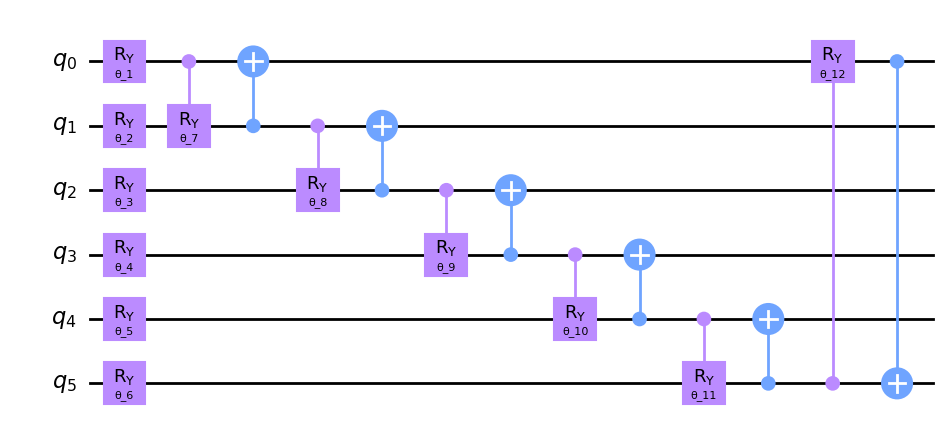

In [105]:
num_qub=6
qc = QuantumCircuit(num_qub)
 

j=0
for i in np.arange(0,num_qub-1):
    qc.cry(Parameter('θ_' + str(j)),i,i+1) 
    j +=1
    qc.cnot(i+1, i)
for i in np.arange(0,num_qub-1):
    qc.ry(Parameter('θ_' + str(j)),i) 
    j +=1
    qc.cnot(i, i+1)    
    
qc.draw()
ansatz = qc


# ansatz = EfficientSU2(12, entanglement='linear', reps=1, skip_final_rotation_layer=True).decompose()
# ansatz.draw(fold=300)

num_qub=6
j=0
qc = QuantumCircuit(num_qub)
#qc.ry(Parameter('θ_' + str(j)),0) 
j +=1


for i in np.arange(0,num_qub):
    qc.ry(Parameter('θ_' + str(j)),i)
    j +=1
    #qc.cnot(i, i+1)
 
for i in np.arange(0,num_qub-1):
    qc.cry(Parameter('θ_' + str(j)),i,i+1) 
    j +=1
    qc.cnot(i+1, i)

 
qc.cry(Parameter('θ_' + str(j)),5,0) 
j +=1
qc.cnot(0, 5)

#qc.cry(Parameter('θ_' + str(j)),0,5) 
ansatz=qc
ansatz.draw('mpl')

In [106]:

#ALL IN A SINGLE CELL

ansatz_opt = transpile(ansatz, simulator)

intermediate_info = []
def callback(value):
        intermediate_info.append(value)

optimizer = NFT(maxiter=500)

estimator = Estimator([ansatz_opt], [ham])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham)
end = time()

print(result.eigenvalue)
print(f'execution time (s): {end - start:.2f}')



-5.614765342761478
execution time (s): 16.35


In [95]:
result.optimal_circuit

In [104]:
def to_bin(v):
    coef_bin = []
    large = np.log2(len(v))
    for i in range(len(v)):
        if abs(v[i])> 1e-5:
            py_binario = bin(i)[2:]
            binario = '0'*int((large - len(py_binario)))+py_binario
            coef_bin += [(binario,v[i])] 
    return coef_bin

from qiskit.quantum_info import Statevector

psi = Statevector.from_instruction(result.optimal_circuit)

coso = to_bin(np.array(psi).real.round(3))
for tup in coso:
    if abs(tup[1]) > 0.05:
        print(tup)

('000111', -0.438)
('001011', -0.168)
('001101', 0.493)
('010011', -0.054)
('010101', 0.159)
('100110', 0.446)
('101010', 0.171)
('101100', -0.501)
('110010', 0.055)
('110100', -0.162)


### Results analysis

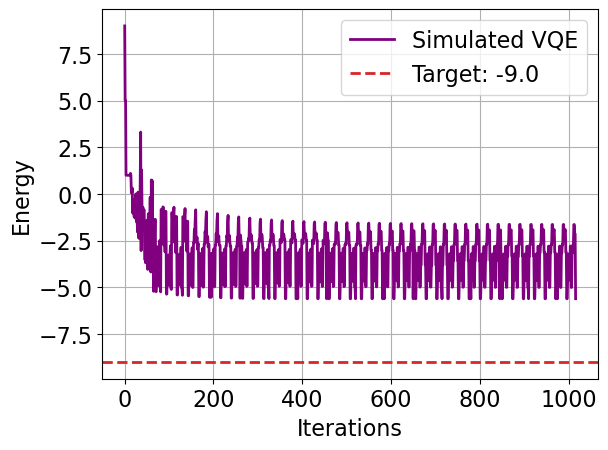

In [97]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [40]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -9.0000000000
Computed ground state energy: -3.0000000000
Relative error: 0.66666667
